In [2]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt 
import torchvision 
import torchvision.models as models 

from torchvision import datasets, transforms 
from torchvision.datasets import CIFAR10 
from torch.utils.data import DataLoader 
from torch.optim import Adam 
from torchsummary import summary 

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Data

In [5]:
train_transform = transforms.Compose(
    [ 
        transforms.Resize((224, 224)), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]), 
        transforms.RandomErasing(p=0.75, 
                                 scale=(0.01, 0.3), 
                                 ratio=(1.0, 1.0), 
                                 value=0, 
                                 inplace=True)
    ]
)

test_transform = transforms.Compose([ 
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_datasets = datasets.ImageFolder('../data50/train', transform=train_transform)
test_datasets = datasets.ImageFolder('../data50/validation', transform=test_transform)

train_loader = DataLoader(train_datasets, batch_size=32, shuffle=True)
test_loader = DataLoader(test_datasets, batch_size=32, shuffle=False)

#### Model

In [7]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
f_extractor = vgg16.features 

model = nn.Sequential(f_extractor, 
                      nn.Flatten(), 
                      nn.Dropout(0.3), 
                      nn.Linear(512*7*7, 512), 
                      nn.ReLU(), 
                      nn.Dropout(0.3), 
                      nn.Linear(512, 2))

model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

#### Train

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [9]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0 
    running_correct = 0 
    total = 0 
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total 
    test_loss = test_loss / len(test_loader)
    return test_loss, accuracy

In [10]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 10

In [12]:
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0 
    running_correct = 0 
    total = 0 

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * running_correct / total 
    epoch_loss = running_loss / (i + 1)

    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


Epoch [1/10], Loss: 0.4849, Accuracy: 63.00%, Test Loss: 0.1568, Test Accuracy: 94.50%
Epoch [2/10], Loss: 0.1017, Accuracy: 98.00%, Test Loss: 0.1494, Test Accuracy: 94.80%
Epoch [3/10], Loss: 0.0125, Accuracy: 99.00%, Test Loss: 0.2076, Test Accuracy: 95.40%
Epoch [4/10], Loss: 0.0107, Accuracy: 99.00%, Test Loss: 1.5217, Test Accuracy: 86.30%
Epoch [5/10], Loss: 0.0343, Accuracy: 99.00%, Test Loss: 0.2953, Test Accuracy: 94.60%
Epoch [6/10], Loss: 0.0448, Accuracy: 98.00%, Test Loss: 1.8108, Test Accuracy: 81.20%
Epoch [7/10], Loss: 0.1828, Accuracy: 95.00%, Test Loss: 1.4471, Test Accuracy: 75.80%
Epoch [8/10], Loss: 0.1046, Accuracy: 97.00%, Test Loss: 0.4110, Test Accuracy: 89.80%
Epoch [9/10], Loss: 0.0521, Accuracy: 97.00%, Test Loss: 0.2286, Test Accuracy: 92.70%
Epoch [10/10], Loss: 0.0183, Accuracy: 99.00%, Test Loss: 0.1184, Test Accuracy: 95.30%


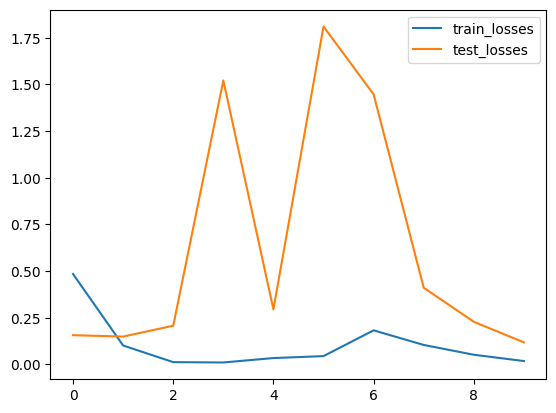

In [13]:
import matplotlib.pyplot as plt 

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

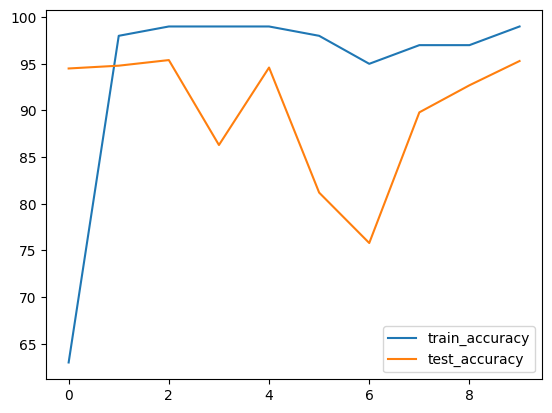

In [14]:
import matplotlib.pyplot as plt 

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()